In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mysql.connector
import ast
from collections import Counter
import pymysql #make the fetch_all() result in pd dataframe format
from fa2 import ForceAtlas2 #only works in python 3.8, so venv is created to run in 3.8
import networkx as nx
import pandasql as ps
from community import community_louvain
import matplotlib.cm as cm
import math
import random

In [7]:
tweet_db = pymysql.connect(host='localhost', user = 'root', password = 'cats', database = 'Tweet_hashtags')

In [8]:
#pd.read_sql_query reads sql query and return pd df
hashtag_directlinked_prob = pd.read_sql_query("""SELECT t6.hashtag_id, t6.linked_hashtag_id, t6.numerator, t5.denominator, t6.numerator/t5.denominator AS directlinked_prob
-- denominator table

FROM 

  (SELECT t4.hashtag_id, SUM(t4.tweet_sum) AS denominator 
  FROM
  (SELECT t1.tweet_id, t1.hashtag_id, t1.count, t3.tweet_sum
   FROM tweet_hashtags AS t1
   JOIN 
    (SELECT t2.tweet_id, SUM(t2.count) AS tweet_sum
    FROM tweet_hashtags AS t2
    GROUP BY tweet_id ) AS t3
   ON t1.tweet_id=t3.tweet_id) AS t4
  GROUP BY t4.hashtag_id) AS t5  
  
JOIN 

-- numerator table
  (SELECT 
   t1.hashtag_id, t2.hashtag_id AS linked_hashtag_id, sum(t2.count) AS numerator
  FROM tweet_hashtags AS t1
  JOIN tweet_hashtags AS t2
  ON (t1.tweet_id = t2.tweet_id AND t1.hashtag_id <> t2.hashtag_id)
  GROUP BY t1.hashtag_id, t2.hashtag_id) AS t6
  
ON t5.hashtag_id = t6.hashtag_id""", tweet_db)

In [9]:
# Create ForceAtlas2 object with desired parameters
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True, # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=0.00001,

                          # Log
                          verbose=True)

In [10]:
hashtag_full = pd.read_sql_query("SELECT * FROM hashtags", tweet_db)

In [11]:
avg_directlinked_prob = ps.sqldf("""SELECT t1.hashtag_id, t1.linked_hashtag_id, (t1.directlinked_prob+t2.directlinked_prob)/2 AS avg_directlinked_prob
                  FROM hashtag_directlinked_prob AS t1
                   JOIN hashtag_directlinked_prob AS t2
                   ON t1.hashtag_id = t2.linked_hashtag_id AND t1.linked_hashtag_id = t2.hashtag_id AND t1.hashtag_id > t2.hashtag_id;""")
#ps.sqldf treat pandas df as sql table and give back a pandas df
#avg_directlinked_prob is the mean of the directlinked_prob from both directions

In [12]:
hashtag_countsum = pd.read_sql_query("""SELECT hashtag_id, SUM(count) AS count_sum
                    FROM tweet_hashtags
                    GROUP BY hashtag_id
                    HAVING SUM(count) > 10
                    ORDER BY count_sum DESC;""", tweet_db)
selected_hashtag_id = hashtag_countsum['hashtag_id']
selected_hashtag_id = np.array(selected_hashtag_id)

In [13]:
need_to_drop_row_index = []
for row_index, row in avg_directlinked_prob.iterrows():
    if row["hashtag_id"] not in selected_hashtag_id or row["linked_hashtag_id"] not in selected_hashtag_id:
        need_to_drop_row_index.append(row_index)
updated_avg_directlinked_prob = avg_directlinked_prob.drop(need_to_drop_row_index)
            

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 577.55it/s]


BarnesHut Approximation  took  0.03  seconds
Repulsion forces  took  0.08  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.02  seconds


/Users/jingwenlin/Desktop/ML/ML projects/tweet_hashtag_cluster_network/venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50732 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/jingwenlin/Desktop/ML/ML projects/tweet_hashtag_cluster_network/venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/jingwenlin/Desktop/ML/ML projects/tweet_hashtag_cluster_network/venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48708 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/jingwenlin/Desktop/ML/ML projects/tweet_hashtag_cluster_network/venv/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50500 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/jingwenlin/Desktop/ML/ML projects/tweet_hashtag_c

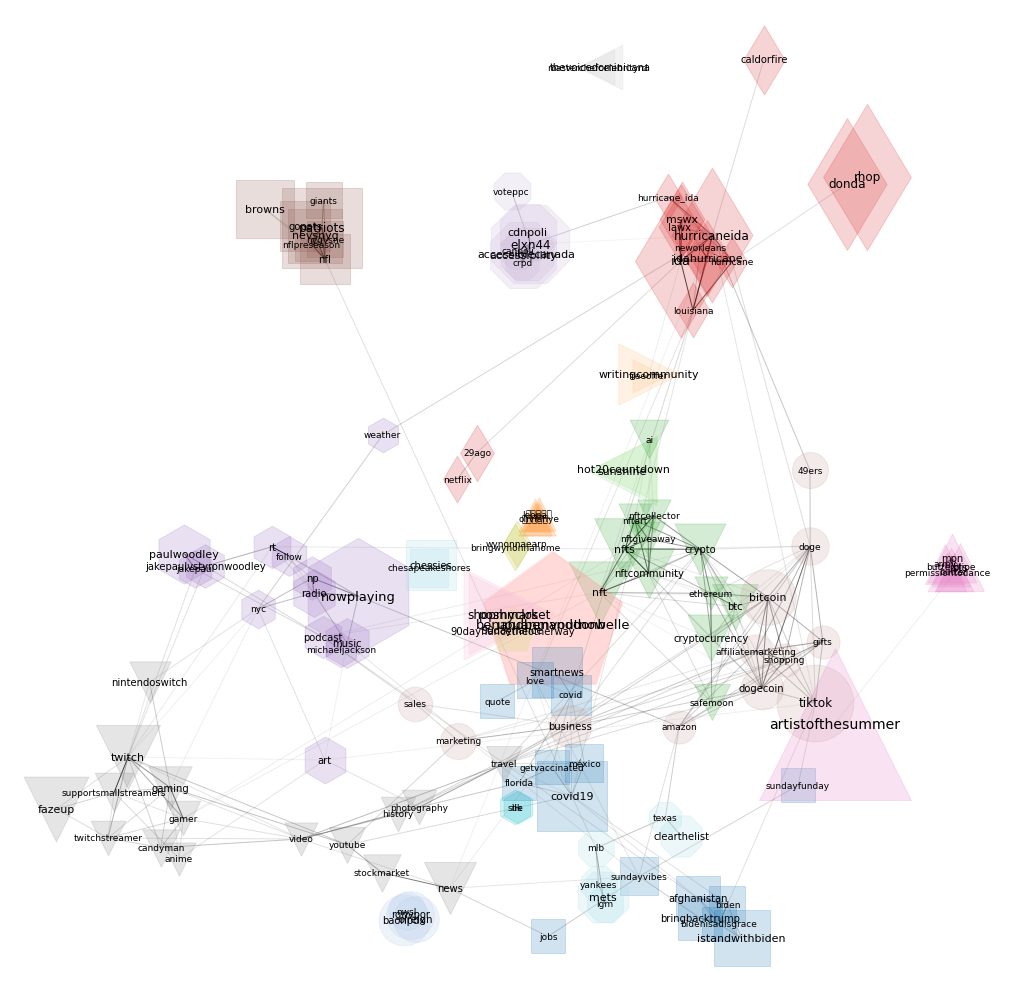

In [14]:
plt.figure(figsize=(18,18))
G=nx.Graph()

for row_index, row in updated_avg_directlinked_prob.iterrows():
    node_a = hashtag_full.loc[row["hashtag_id"], 'hashtag']
    node_b = hashtag_full.loc[row["linked_hashtag_id"], 'hashtag']
    G.add_edge(node_a, node_b, weight=row["avg_directlinked_prob"]) #automatically add node

#print(nx.info(G))

partition = community_louvain.best_partition(G, resolution = 0.6, random_state = 0)

random.seed(0)#fix forceatlas2
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=100)
cmap = cm.get_cmap('tab20', max(partition.values()) + 1)
shapes = 'so^>v<dph8'

def id_to_shape(id):
    id_shape = shapes[id%len(shapes)]
    return id_shape

for node, id in partition.items():
    chosen_hashtag_id = hashtag_full.loc[hashtag_full['hashtag'] == node, 'hashtag_id'].values[0]
    #node_size: fetch the count_sum/node_size given hashtag_id/node, then * 100
    node_size = (hashtag_countsum.loc[hashtag_countsum['hashtag_id'] == chosen_hashtag_id, 'count_sum'].values[0]) * 100
    node_position = {}
    node_position[node] = positions[node]
    
    nx.draw_networkx_nodes(G, pos = node_position, nodelist = [node], node_size = node_size,
                           node_color=[cmap.colors[id]], node_shape=id_to_shape(id), alpha=0.2
                           )
    
    nx.draw_networkx_labels(G, pos = node_position, labels ={node:node}, 
                            font_size = math.ceil(1.3*math.log(max(node_size-597, 1.0))))

for node1, node2 in G.edges():
    weight = G.get_edge_data(node1, node2)['weight']
    nx.draw_networkx_edges(G, pos = positions, edgelist = [(node1, node2)], alpha=min(1, weight*10))

plt.axis('off')
plt.show()
